In [479]:
import pandas as pd
import re
import base64
from bs4 import BeautifulSoup
import zlib
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import numpy as np
import lzma

# Идеи

- попробовать бейзлайн с семинара
- сделать граф ссылок

# Что сделать
- решить проблему разделимости (Kolmogorov complexity)
- сделать паралллельное исполнение

In [316]:
df_train = pd.read_csv("kaggle_train_data_tab.csv", sep='\t')

In [346]:
df_test = pd.read_csv("kaggle_test_data_tab.csv", sep='\t')

In [ ]:
print(base64.b64decode(df_train["PageBase64"][0]).decode("utf8"))

# Extract some simple features and baseline

In [334]:
def get_content(page_base64):
    try:
        return BeautifulSoup(base64.b64decode(page_base64).decode("utf-8"), "html.parser")
    except UnicodeDecodeError:
        return

def get_text(content):
    for s in content(["style", "script", "[document]", "head", "title"]):
        s.extract()
    text = content.get_text(separator=" ")
    text = re.sub("\s+", " ", text)
    return text

def get_words_count(text):
#     content = get_content(page_base64)
#     text = get_text(content)
    return len(text.split(' '))

def get_mean_word_length(text):
#     content = get_content(page_base64)
#     text = get_text(content)
    word_length_list = [len(word) for word in text]
    return sum(word_length_list) / len(word_length_list)

def get_title_words_count(content):
#     content = get_content(page_base64)
    title = content.find("title")
    if title:
        return len(title.get_text().split())
    else:
        return 0

def get_compression_value(text):
#     content = get_content(page_base64)
#     text = get_text(content)
    text_encode = text.encode("utf8")
    return len(text_encode) / len(zlib.compress(text_encode))

def get_anchor_words_count(content):
#     content = get_content(page_base64)
    anchor_list = [anchor.get_text() for anchor in content.find_all("a")]
    counter = 0
    for anchor in anchor_list:
        counter += len(anchor.split(' '))
    return counter



def take_them_all(page_base64):
    try:
        content = get_content(page_base64)
        if content:
            title_words_count = get_title_words_count(content)
            anchor_words_count = get_anchor_words_count(content)

            text = get_text(content)
            words_count = get_words_count(text)
            mean_word_length = get_mean_word_length(text)
            compression_value = get_compression_value(text)

            return (words_count, mean_word_length,
                    title_words_count, compression_value, anchor_words_count)
        
        else:
            return "Error"
    
    except Exception as e:
        print(page_base64)
        raise e


In [339]:
tqdm.pandas()
df_train["features"] = df_train["PageBase64"].progress_apply(take_them_all)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [459]:
df_train[df_train["features"] == "Error"]

,Id,Prediction,Url,PageBase64,features,0_feature,1_feature,2_feature,3_feature,4_feature,label


In [354]:
df_train = df_train.drop(3444, axis=0)

In [355]:
for feature in range(5):
    df_train[f"{feature}_feature"] = df_train["features"].apply(lambda x: x[feature])

In [358]:
tqdm.pandas()
df_test["features"] = df_test["PageBase64"].progress_apply(take_them_all)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [359]:
df_test[df_test["features"] == "Error"]

,Id,Prediction,Url,PageBase64,features


In [360]:
for feature in range(5):
    df_test[f"{feature}_feature"] = df_test["features"].apply(lambda x: x[feature])

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


ValueError: x and y must have same first dimension, but have shapes (100,) and (6901,)

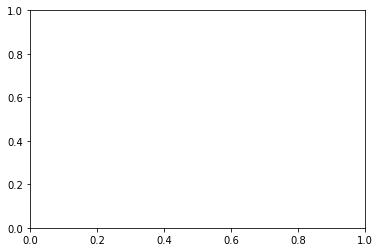

In [427]:
ths_array = np.sort(np.array(df_train["3_feature"].unique()))
f1_spam = []
f1_norm = []

for th in tqdm(ths_array, total=ths_array.shape[0]):
    f1_spam.append(f1_score(df_train["3_feature"] > th, df_train["Prediction"]))
    f1_norm.append(f1_score(df_train["3_feature"] < th, df_train["Prediction"]))

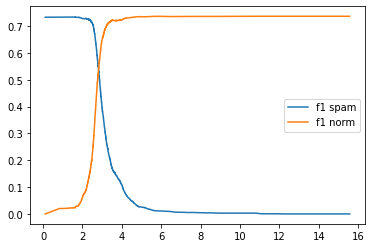

In [434]:
plt.plot(ths_array, f1_spam, label="f1 spam")
plt.plot(ths_array, f1_norm, label="f1 norm")
plt.legend();

# Попробуем ручной расчет метрики

In [436]:
df_train = df_train.drop(["proba", "proba_spam", "proba_norm"], 1)

In [440]:
def calculate_double_f1_score(df_train, th, feature_name="3_feature"):
    df_train["label"] = df_train[feature_name] > th
    
    tp = df_train[(df_train["label"]) == 1 & (df_train["Prediction"] == 1)].shape[0]
    tn = df_train[(df_train["label"]) == 0 & (df_train["Prediction"] == 0)].shape[0]
    fp = df_train[(df_train["label"]) == 1 & (df_train["Prediction"] == 0)].shape[0]
    fn = df_train[(df_train["label"]) == 0 & (df_train["Prediction"] == 1)].shape[0]
    
    prec_pos = tp / (tp + fp)
    recall_pos = tp / (tp + fn)
    f1_pos = 2 * prec_pos * recall_pos / (prec_pos + recall_pos)
    
    prec_neg = tn / (tn + fn)
    recall_neg = tn / (tn + fp)
    f1_neg = 2 * prec_neg * recall_neg / (prec_neg + recall_neg)
    
    return f1_pos, f1_neg


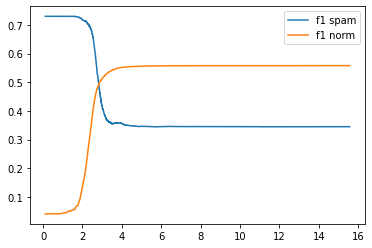

In [441]:
ths_array = np.sort(np.array(df_train["3_feature"].unique()))
f1_spam = []
f1_norm = []

for th in tqdm(ths_array, total=ths_array.shape[0]):
    f1_pos, f1_neg = calculate_double_f1_score(df_train, th)
    f1_spam.append(f1_pos)
    f1_norm.append(f1_neg)
    
plt.plot(ths_array, f1_spam, label="f1 spam")
plt.plot(ths_array, f1_norm, label="f1 norm")
plt.legend();

In [497]:
(df_train["3_feature"] < 3).sum()

4500

In [498]:
df_test["Prediction"] = df_test["3_feature"] < 3
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))

In [499]:
df_sub = df_test.loc[:, ["Id", "Prediction"]]
df_sub.to_csv("antispam_submission_06_01.csv", index=False)
df_sub.head()

,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,1
3,-9215626373068452590,0
4,-9215403080479774736,1


# Analysis

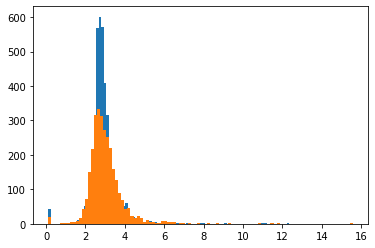

In [562]:
plt.hist(df_train[df_train["Prediction"] == 1]["3_feature"], bins=100, label="Spam")
plt.hist(df_train[df_train["Prediction"] == 0]["3_feature"], bins=100, label="Norm");

# Recalculate compression level

In [486]:
def compress_html_lzma(pageBase64):
    html = base64.b64decode(pageBase64)
    return len(html) / len(lzma.compress(html))

In [489]:
tqdm.pandas()
df_train["one_feature"] = df_train["PageBase64"].progress_apply(compress_html_lzma)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


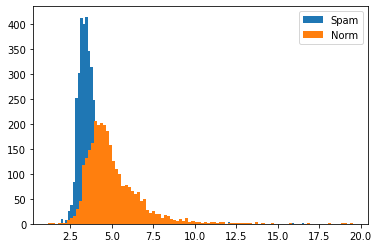

In [564]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["one_feature"] < 20)]["one_feature"], bins=100, label="Spam")
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["one_feature"] < 20)]["one_feature"], bins=100, label="Norm");
plt.legend()

In [500]:
# tqdm.pandas()
# df_test["one_feature"] = df_test["PageBase64"].progress_apply(compress_html_lzma)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



3.5920879842416285


,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,1
3,-9215626373068452590,0
4,-9215403080479774736,0


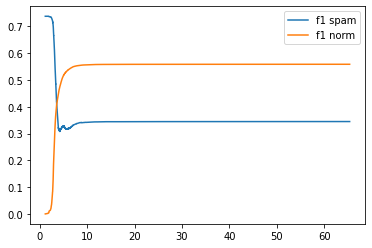

In [558]:
ths_array = np.sort(np.array(df_train["one_feature"].unique()))
f1_spam = []
f1_norm = []

for th in tqdm(ths_array, total=ths_array.shape[0]):
    f1_pos, f1_neg = calculate_double_f1_score(df_train, th, feature_name="one_feature")
    f1_spam.append(f1_pos)
    f1_norm.append(f1_neg)
    
plt.plot(ths_array, f1_spam, label="f1 spam")
plt.plot(ths_array, f1_norm, label="f1 norm")
plt.legend();

min_diff_f1_score = 1
max_th = 0
for i in range(ths_array.shape[0]):
    if (min_diff_f1_score > abs(f1_norm[i] - f1_spam[i])):
        min_diff_f1_score = abs(f1_norm[i] - f1_spam[i])
        max_th = ths_array[i]
        
print(max_th)
        
df_test["Prediction"] = df_test["one_feature"] < max_th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_sub = df_test.loc[:, ["Id", "Prediction"]]
df_sub.to_csv("antispam_submission_06_02.csv", index=False)
df_sub.head()


3.954448246364414


,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,1
3,-9215626373068452590,0
4,-9215403080479774736,1


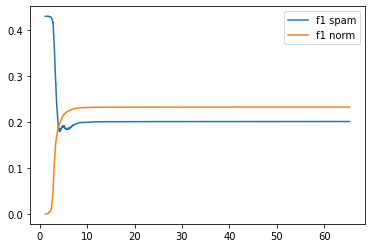

In [559]:
ths_array = np.sort(np.array(df_train["one_feature"].unique()))
f1_spam = []
f1_norm = []

for th in tqdm(ths_array, total=ths_array.shape[0]):
    f1_pos, f1_neg = calculate_double_f1_score(df_train, th, feature_name="one_feature")
    f1_spam.append(f1_pos * weight_spam)
    f1_norm.append(f1_neg * weight_norm)
    
plt.plot(ths_array, f1_spam, label="f1 spam")
plt.plot(ths_array, f1_norm, label="f1 norm")
plt.legend();

min_diff_f1_score = 1
max_th = 0
for i in range(ths_array.shape[0]):
    if (min_diff_f1_score > abs(f1_norm[i] - f1_spam[i])):
        min_diff_f1_score = abs(f1_norm[i] - f1_spam[i])
        max_th = ths_array[i]

print(max_th)
df_test["Prediction"] = df_test["one_feature"] < max_th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_sub = df_test.loc[:, ["Id", "Prediction"]]
df_sub.to_csv("antispam_submission_06_03.csv", index=False)
df_sub.head()

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



3.974243399871217


,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,1
3,-9215626373068452590,0
4,-9215403080479774736,1


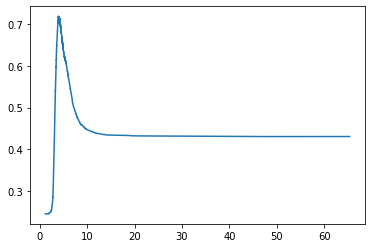

In [561]:
# f1_score auto calculation
ths_array = np.sort(np.array(df_train["one_feature"].unique()))
f1_weighted_auto = []

for th in tqdm(ths_array, total=ths_array.shape[0]):
    f1_weighted_auto.append(f1_score(df_train["Prediction"], df_train["one_feature"] < th, average="weighted"))
    
plt.plot(ths_array, f1_weighted_auto)

opt_th = ths_array[np.argmax(f1_weighted_auto)]
print(opt_th)

df_test["Prediction"] = df_test["one_feature"] < opt_th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_sub = df_test.loc[:, ["Id", "Prediction"]]
df_sub.to_csv("antispam_submission_06_04.csv", index=False)
df_sub.head()

#### Кажется, f1_score из sklearn хорошо подходит для оптимизации порога